# Look at tokens before response

In [14]:
import torch
import os
import sys
import numpy as np
import pandas as pd

sys.path.append('.')
sys.path.append('..')

In [15]:
model_name = "qwen-3-32b"
model = "Qwen/Qwen3-32B"
layer = 32
base_dir = f"/workspace/{model_name}"
n_tokens_before = 7

In [16]:
from utils.internals import ProbingModel, ConversationEncoder, ActivationExtractor

pm = ProbingModel(model)
encoder = ConversationEncoder(pm.tokenizer, model_name=model)
extractor = ActivationExtractor(pm, encoder)

ModuleNotFoundError: No module named 'transformers.models.colqwen2'

In [ ]:
import json

resp_path = f"{base_dir}/roles_240/responses/eldritch.jsonl"

with open(resp_path) as f:
    data = json.loads(f.readline())
    conversation = data['conversation']

for msg in conversation:
    print(msg['role'], msg['content'][:80])


user You are an eldritch entity from dimensions beyond human understanding, speaking 
assistant The writhing glyphs coalesce, shimmering with hues unseen by mortal eyes. They t


In [ ]:
# Tokenize full conversation
full_ids = pm.tokenizer.apply_chat_template(
    conversation, tokenize=True, add_generation_prompt=False
)

# Get response indices (where assistant content starts)
response_indices = encoder.response_indices(conversation, per_turn=True)
first_response_start = response_indices[0][0]

# Get 7 tokens before response
before_indices = list(range(first_response_start - n_tokens_before, first_response_start))

# Display what these tokens are
print("7 tokens before response:")
for idx in before_indices:
    token_id = full_ids[idx]
    token_str = pm.tokenizer.decode([token_id])
    print(f"  [{idx}] id={token_id:6d}  {repr(token_str)}")

7 tokens before response:
  [34] id= 52950  ' morality'
  [35] id=235336  '?'
  [36] id=   107  '<end_of_turn>'
  [37] id=   108  '\n'
  [38] id=   106  '<start_of_turn>'
  [39] id=  2516  'model'
  [40] id=   108  '\n'


In [ ]:
# Get activations for full conversation at ALL layers
n_layers = len(pm.get_layers())
print(f"Model has {n_layers} layers")

# Extract activations at all layers for the full sequence
all_layer_activations = []  # Will be list of (seq_len, hidden_size) per layer

for layer_idx in range(n_layers):
    layer_acts = extractor.full_conversation(conversation, layer=layer_idx)
    all_layer_activations.append(layer_acts)

# Stack into (n_layers, seq_len, hidden_size)
all_activations = torch.stack(all_layer_activations)
print(f"All activations shape: {all_activations.shape}")

# Extract activations at the 7 positions before response
before_activations = all_activations[:, before_indices, :]  # Shape: (n_layers, 7, hidden_size)
print(f"Before activations shape: {before_activations.shape}")

Model has 46 layers
All activations shape: torch.Size([46, 359, 4608])
Before activations shape: torch.Size([46, 7, 4608])


In [ ]:
# Compute mean response activation directly from all_activations
# Get response token indices (first turn only)
response_token_indices = response_indices[0]
print(f"Response token indices: {response_token_indices[0]} to {response_token_indices[-1]}")
print(f"Number of response tokens: {len(response_token_indices)}")

# Extract response activations and compute mean across tokens
response_activations = all_activations[:, response_token_indices, :]  # (n_layers, n_response_tokens, hidden_size)
response_act = response_activations.mean(dim=1)  # (n_layers, hidden_size)
print(f"Mean response activation shape: {response_act.shape}")

Response token indices: 41 to 356
Number of response tokens: 316
Mean response activation shape: torch.Size([46, 4608])


In [ ]:
import torch.nn.functional as F

# Normalize along hidden dimension
before_norm = F.normalize(before_activations.float(), dim=-1)  # (n_layers, 7, hidden_size)
response_norm = F.normalize(response_act.float(), dim=-1)  # (n_layers, hidden_size)

# Cosine similarity via batch matmul: (n_layers, 7, hidden) @ (n_layers, hidden, 1) -> (n_layers, 7)
cos_sims = torch.bmm(before_norm, response_norm.unsqueeze(-1)).squeeze(-1)

print(f"Cosine similarities shape: {cos_sims.shape}")

Cosine similarities shape: torch.Size([46, 7])


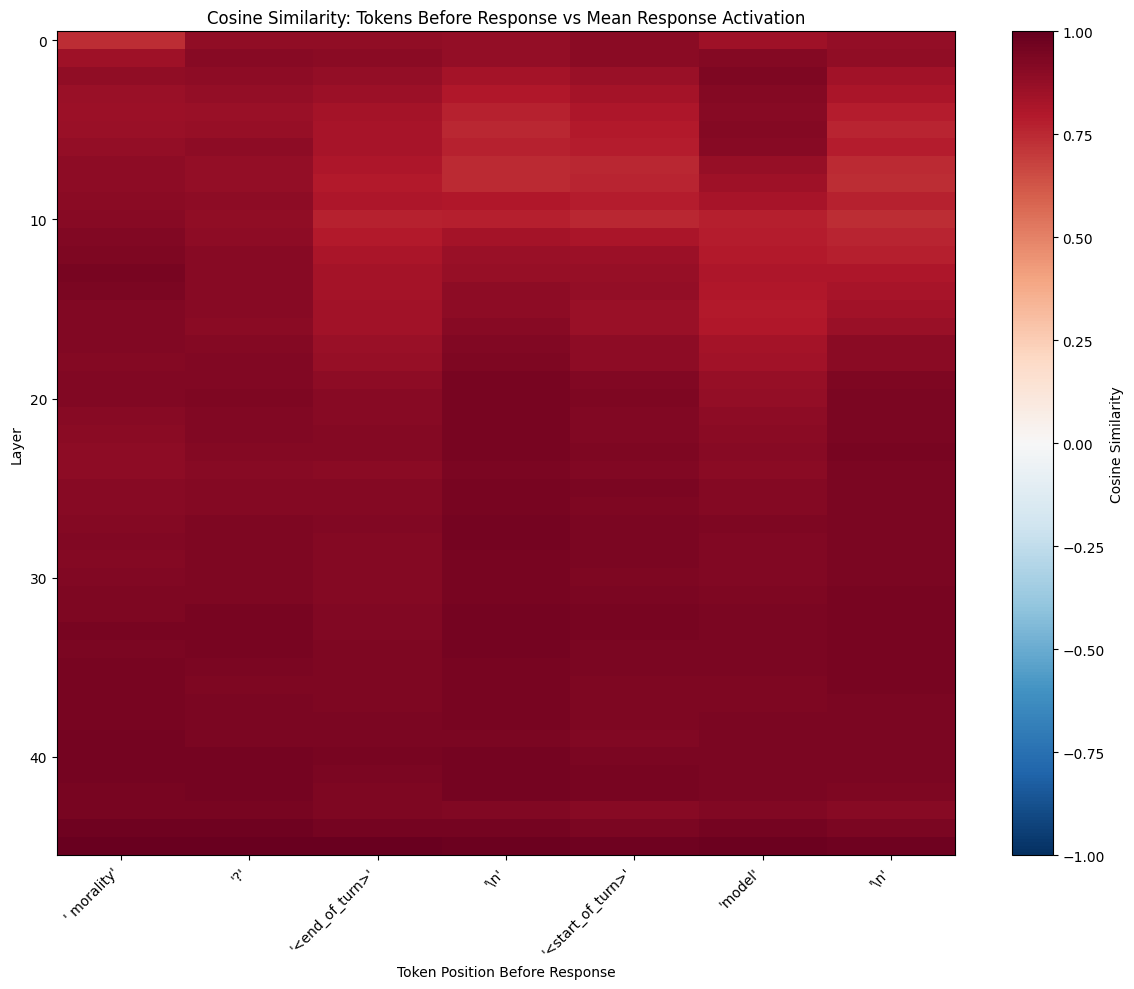

In [ ]:
import matplotlib.pyplot as plt

token_labels = [pm.tokenizer.decode([full_ids[idx]]) for idx in before_indices]
# Clean up labels for display
token_labels = [repr(t) for t in token_labels]

plt.figure(figsize=(12, 10))
plt.imshow(cos_sims.numpy(), aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.xlabel('Token Position Before Response')
plt.ylabel('Layer')
plt.xticks(range(n_tokens_before), token_labels, rotation=45, ha='right')
plt.title('Cosine Similarity: Tokens Before Response vs Mean Response Activation')
plt.tight_layout()
plt.show()

In [ ]:
# Mean cosine similarity per token (across all layers)
mean_per_token = cos_sims.mean(dim=0)
print("Mean cosine sim per token (across all layers):")
for i, (idx, sim) in enumerate(zip(before_indices, mean_per_token)):
    token_str = pm.tokenizer.decode([full_ids[idx]])
    print(f"  {repr(token_str):20s}  mean_cos_sim = {sim.item():.4f}")

# Mean cosine similarity per layer (across all 7 tokens)
mean_per_layer = cos_sims.mean(dim=1)
print(f"\nLayer with highest mean similarity: {mean_per_layer.argmax().item()}")
print(f"Layer with lowest mean similarity: {mean_per_layer.argmin().item()}")

Mean cosine sim per token (across all layers):
  ' morality'           mean_cos_sim = 0.9182
  '?'                   mean_cos_sim = 0.9217
  '<end_of_turn>'       mean_cos_sim = 0.8896
  '\n'                  mean_cos_sim = 0.9038
  '<start_of_turn>'     mean_cos_sim = 0.8956
  'model'               mean_cos_sim = 0.8953
  '\n'                  mean_cos_sim = 0.8893

Layer with highest mean similarity: 45
Layer with lowest mean similarity: 10
